## Installing Required Libraries

To run this practical, you need to install the following libraries:

- `tensorflow`: Deep learning framework.
- `tensorflow_hub`: Pre-trained models repository.
- `tensorflow_datasets`: Collection of datasets for deep learning.
- `scikit-learn`: Machine learning tools for data splitting, scaling, and evaluation.
- `mlxtend`: For plotting confusion matrices.
- `pandas`: Data manipulation.
- `numpy`: Numerical operations.
- `matplotlib`: Plotting and visualization.
- `seaborn`: Statistical data visualization.
- `tqdm`: Progress bar for loops.
- `warnings`: To suppress warnings.

You can install the required libraries using the following command:

```bash
pip install tensorflow tensorflow-hub tensorflow-datasets scikit-learn mlxtend pandas numpy matplotlib seaborn tqdm


In [1]:
# Importing necessary libraries for model training, evaluation, and data processing
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

%matplotlib inline  # Display plots inline in Jupyter notebooks


UsageError: unrecognized arguments: # Display plots inline in Jupyter notebooks


In [2]:
# Load the IMDB reviews dataset from TensorFlow Datasets
# Splitting the dataset into 60% training, 20% validation, and 20% test sets
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",   # Name of the dataset
    split=('train[:60%]', 'train[60%:]', 'test'),  # Splits for training, validation, and testing
    as_supervised=True)  # Returns tuple of (text, label)


In [3]:
# Fetch a batch of 10 examples from the training dataset for inspection
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

# Display the labels of the fetched batch
train_labels_batch


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

In [4]:
# Specify the URL of the pre-trained embedding model hosted on TensorFlow Hub
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"

# Create the TensorFlow Hub embedding layer, making it trainable
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)


In [5]:
# Create the model architecture using Keras
inputs = tf.keras.Input(shape=(), dtype=tf.string, name="input_text")  # Input layer accepting text

# Apply the pre-trained embedding layer inside a Lambda layer
x = tf.keras.layers.Lambda(lambda x: hub_layer(x), output_shape=(128,))(inputs)  # Convert text to embeddings

# Add hidden Dense layers with ReLU activation
x = tf.keras.layers.Dense(32, activation='relu', name='hidden-layer-2')(x)  # First dense layer
x = tf.keras.layers.Dense(16, activation='relu', name='hidden-layer-3')(x)  # Second dense layer

# Output layer with a single unit for binary classification
outputs = tf.keras.layers.Dense(1, name='output-layer')(x)

# Create the Keras Model by specifying input and output layers
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="text_model")

# Display the model summary
model.summary()


Model: "text_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)              │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden-layer-2 (Dense)               │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden-layer-3 (Dense)               │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output-layer (Dense)                 │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

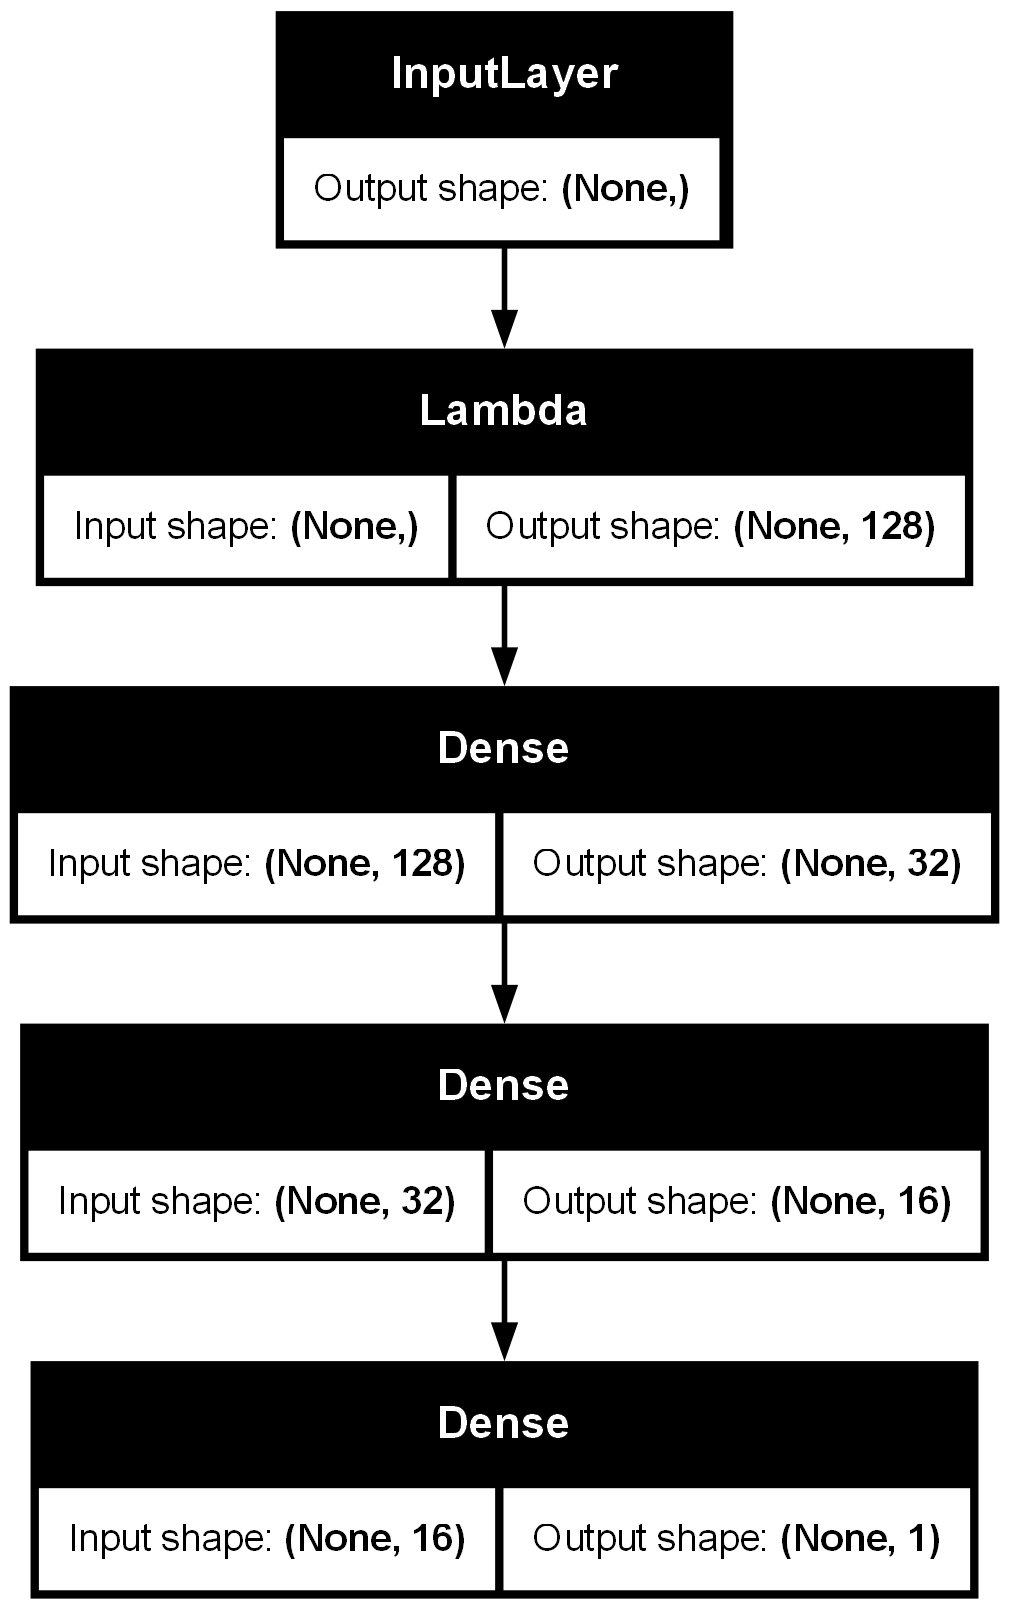

In [6]:
# Plot the architecture of the model, showing layer shapes and connections
tf.keras.utils.plot_model(model, show_shapes=True)


In [7]:
# Compile the model specifying the optimizer, loss function, and evaluation metrics
model.compile(
    optimizer='adam',                # Adam optimizer for efficient training
    loss='binary_crossentropy',      # Binary cross-entropy loss for binary classification
    metrics=['accuracy']            # Track accuracy during training and evaluation
)


In [8]:
# Train the model and store the training history for plotting metrics
history = model.fit(train_data.batch(32), epochs=5, validation_data=validation_data.batch(32))


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6835 - loss: 0.6271 - val_accuracy: 0.7614 - val_loss: 0.5030
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7738 - loss: 0.5392 - val_accuracy: 0.7991 - val_loss: 0.4878
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8048 - loss: 0.4973 - val_accuracy: 0.6072 - val_loss: 1.8567
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6549 - loss: 1.3768 - val_accuracy: 0.6525 - val_loss: 0.6185
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7307 - loss: 0.5474 - val_accuracy: 0.7833 - val_loss: 0.5268


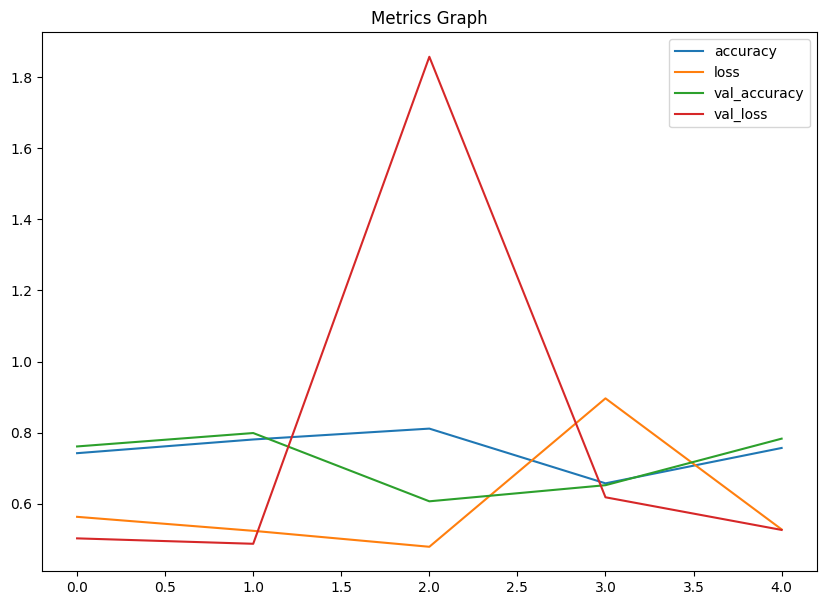

In [9]:
# Plot the training and validation accuracy and loss over epochs
pd.DataFrame(history.history).plot(figsize=(10,7))  # Convert history to DataFrame for easy plotting
plt.title("Metrics Graph")
plt.show()


In [10]:
# Evaluate the model's performance on the test data with batch size of 512
results = model.evaluate(test_data.batch(512), verbose=2)

# Display evaluation results (loss and accuracy)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.3f}")


49/49 - 3s - 61ms/step - accuracy: 0.7802 - loss: 0.5216
loss: 0.522
compile_metrics: 0.780


In [11]:
# Initialize empty lists to store texts and true labels
texts = []
true_labels = []

# Loop through the test dataset to collect texts and labels
for text, label in test_data:
    texts.append(text.numpy())  # Convert text to numpy array
    true_labels.append(label.numpy())  # Convert label to numpy array

# Convert the lists of texts and labels into numpy arrays
texts = np.array(texts)
true_labels = np.array(true_labels)


In [12]:
# Ensure that each text in 'texts' is decoded properly to a string
# If the text is in bytes, decode it to UTF-8
texts = [text.decode('utf-8') if isinstance(text, bytes) else text for text in texts]


In [13]:
# Convert the texts into a numpy array of strings
texts_array = np.array(texts, dtype=str)

# Convert the numpy array of texts into a TensorFlow tensor of type string
texts_tensor = tf.convert_to_tensor(texts_array, dtype=tf.string)


In [14]:
# Use the trained model to predict probabilities for the test texts
predicted_probs = model.predict(texts_tensor)

# Print the predicted probabilities (for visualization)
print(predicted_probs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
[[0.5021886 ]
 [0.8408335 ]
 [0.65946347]
 ...
 [0.20372227]
 [0.84068596]
 [0.85750085]]


In [15]:
# Convert predicted probabilities to binary labels (0 or 1) by thresholding at 0.5
predicted_labels = (predicted_probs > 0.5).astype(int)


In [16]:
# Generate a detailed classification report with precision, recall, F1-score for each class
from sklearn import metrics
report = metrics.classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])

# Display the classification report
print(report)


              precision    recall  f1-score   support

    Negative       0.75      0.84      0.79     12500
    Positive       0.82      0.72      0.77     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000



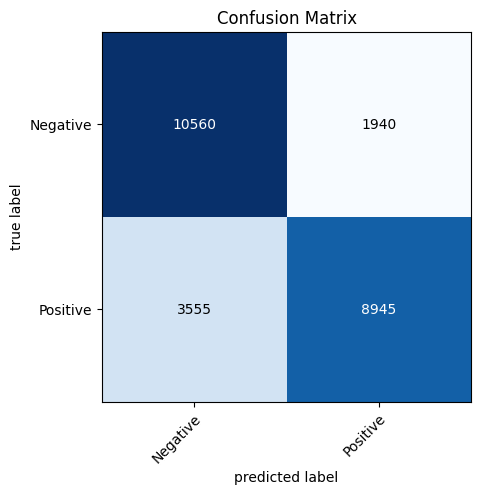

In [17]:
# Generate and plot the confusion matrix for the predictions
cm = metrics.confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using mlxtend's helper function
plot_confusion_matrix(cm, class_names=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.show()
